## Máster en Data Science - Series Temporales

# Easy Prediction Methods
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

En este notebook trataremos modelos sencillos de predicción con el objetivo de comprender su funcionamiento y rendimiento. Esto nos proporcionará la base en los demás modelos que ejecutaremos y evaluaremos a lo largo del proyecto. Aplicaremos los siguientes métodos:
1. Método de la media
2. Método Naive
3. Método de deriva (drift)
4. Intervalos de predicción
5. Predicción mediante transformacione Box-Cox

Evaluaremos estos modelos separando en train y test además de establecer una primera toma de contacto con las métricas de error que usaremos en los posteriores análisis de nuestros modelo, el Mean Squared Error (MSE), el Root Mean Squared Error (RMSE), el Mean Absolute Error (MAE) y el Mean Absolute Percentage Error (MAPE).

In [12]:
# librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sktime.utils.plotting import plot_series
import seaborn as sns
from sktime.utils.plotting import plot_correlations

import warnings

warnings.filterwarnings("ignore")

### Importación de datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv')

### Transformación de datos

In [3]:
df_autobus_month = df_autobus_month[['Periodo', 'Total']]
df_autobus_trim = df_autobus_trim[['Periodo', 'Total']]
df_combined_month = df_combined_month[['Periodo', 'Total']]
df_combined_trim = df_combined_trim[['Periodo', 'Total']]
df_metro_month = df_metro_month[['Periodo', 'Total']]
df_metro_trim = df_metro_trim[['Periodo', 'Total']]

In [5]:
df_autobus_month.set_index('Periodo', inplace=True)
df_autobus_trim.set_index('Periodo', inplace=True)
df_combined_month.set_index('Periodo', inplace=True)
df_combined_trim.set_index('Periodo', inplace=True)
df_metro_month.set_index('Periodo', inplace=True)
df_metro_trim.set_index('Periodo', inplace=True)

In [14]:
df_combined_month.index = pd.to_datetime(df_combined_month.index, format='mixed')
df_combined_month = df_combined_month.resample("M").last()

***

# Predicciones 

## Método de la media

He de mencionar que utilizaré solo y únicamente el dataframe del transporte combinado de la serie mensual para realizar este tipo de predicciones ya que por lo general, son predicciones que no se ajustan a los resultados que esperamos de ellas. Simplemente tendrán un carácter introductorio y servirán de guía para realizar las predicciones de los modelos más robustos como ARIMA, ETS, etc.

Este tipo de predicciones servirán como método de estudio y para poner a prueba los métodos y procedimientos estudiados a lo largo de la asignatura.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

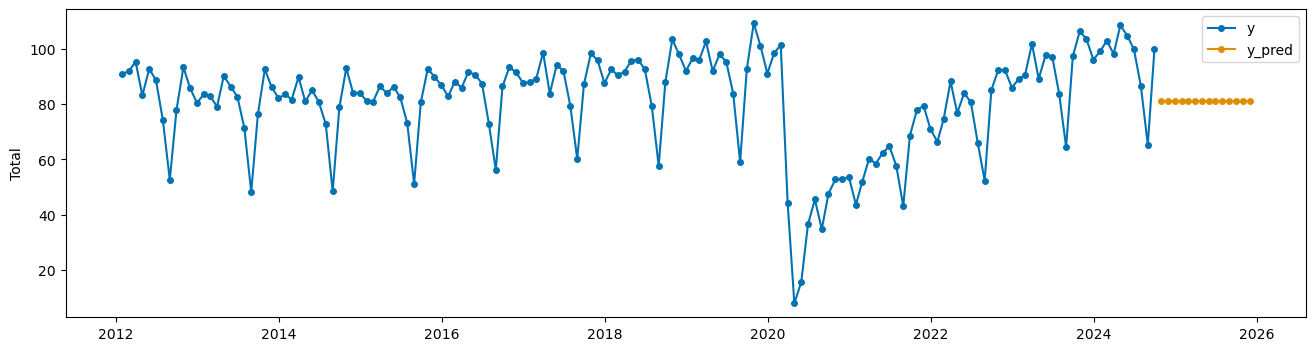

In [15]:

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

# step 1: data specification
y = df_combined_month

# step 2: specifying forecasting horizon
fh = np.arange(1, 15)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="mean")

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])



Observamos como la media no es un buen predictor ya que la serie muestra tendencia.

## Método Naive

El método de predicción de series temporales Naive se basa en la suposición de que el valor futuro más probable es igual al último valor observado en la serie. Es decir, este enfoque utiliza directamente la observación más reciente como la predicción para todos los horizontes futuros. Su simplicidad lo hace útil como referencia o línea base para comparar el desempeño de modelos más complejos. Aunque no considera tendencias, estacionalidades u otras características de los datos, puede ser efectivo en situaciones donde las series temporales son altamente estables o carecen de patrones significativos.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

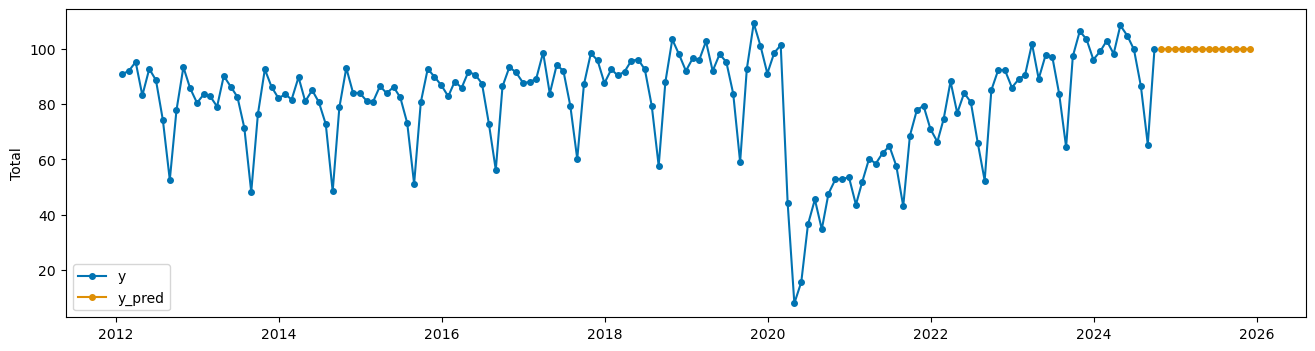

In [16]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 15)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last")

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

Este método Naive se basa en el concepto de 'no sé nada, mi valor de predicción es mi valor de hoy' (strategy = 'last'). Se suele utilizar para predecir rentabilidades de series temporales económicas. En nuestro caso, no genera buenas predicciones ya que siempre predice el mismo valor para todo el periodo.

Esto es incorrecto ya que hemos observado que la serie presenta un comportamiento estacional y una tendencia las cuales esta predicción no se ajusta a ellas.

## Método Naive estacional

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

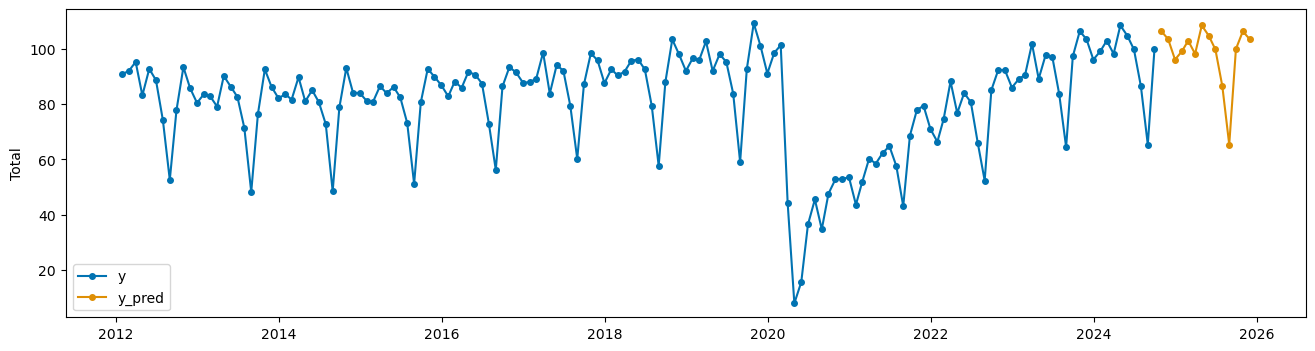

In [24]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 15)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last",sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

En este caso cogemos el último valor pero de la serie estacional, en este caso sp=12 (stational period = 12), ya que son 12 meses. Nos da una predicción del componente estacional sin tener en cuenta el nivel de tendencia de la serie.

## Método de deriva (Drift)


Una variante del método ingenuo permite que las predicciones se ajusten para reflejar una tendencia en los datos. Este ajuste, conocido como deriva, se calcula como el cambio promedio observado en los datos históricos. De esta manera, la predicción para $T+h$ se define como:
$$\hat{y}_{T+h|T} = y_{T} + \frac{h}{T-1}\sum_{t=2}^T (y_{t}-y_{t-1}) = y_{T} + h \left( \frac{y_{T} -y_{1}}{T-1}\right).$$

Esto equivale a trazar una línea recta entre la primera y la última observación de los datos y extrapolarla hacia el futuro.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

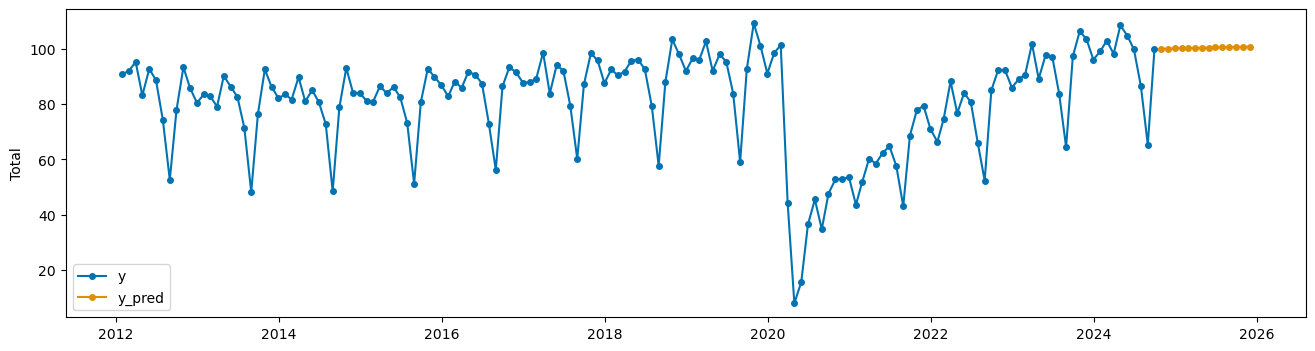

In [27]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 15)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="drift")

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

Nos da una predicción de tendencia, sin tener en cuenta el componente estacional. Si cogemos la naive estacional y sumamos la predicción drift de la tendencia, probablemente sea una buena predicción. La tendencia no es muy acentuada, por ello no notamos una gran diferencia entre esta predicción y la del método Naive.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

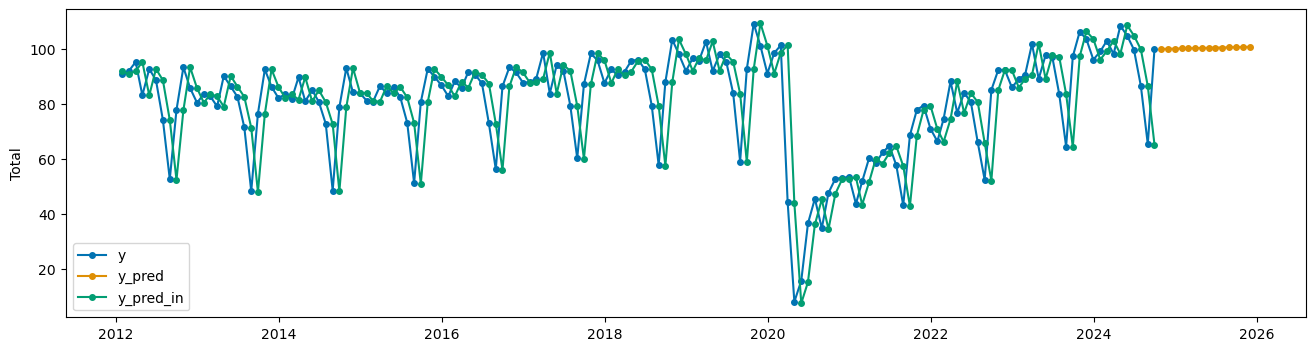

In [28]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 15)
# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="drift")
# forecaster = NaiveForecaster(strategy="last", sp=4)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred_in = forecaster.predict(fh=y.index)
y_pred = forecaster.predict(fh=fh)

# optional: plotting predictions and past data
plot_series(y, y_pred,y_pred_in, labels=["y", "y_pred","y_pred_in"])

Se hacen 2 predicciones, una predicción en la muestra y otra fuera de la muestra, la real es la azul y la verde es la predicción dentro de la muestra, la predicción no es buena ya que está desplazada, retardada. Con drift en el paso 3. 

Para reducir la variabilidad de los datos y facilitar la predicción de datos los convertiremos en logaritmos.

## Intervalos de predicción

Los intervalos de predicción son fundamentales porque proporcionan una estimación del rango en el que es probable que se encuentre un valor futuro, considerando la incertidumbre inherente al modelo y a los datos. Mientras que una predicción puntual ofrece solo un único valor esperado, los intervalos permiten cuantificar la confianza asociada a esa predicción, lo que resulta esencial en la toma de decisiones informadas. Por ejemplo, en situaciones críticas como la gestión de riesgos financieros o la planificación de recursos, entender la posible variabilidad alrededor de una predicción ayuda a mitigar riesgos y a establecer estrategias más robustas frente a diferentes escenarios futuros.

En nuestro caso, los intervalos de predicción de los pasajeros del transporte público de Madrid nos permite saber entre que valores se ajustan las predicciones para ajustar las posibles acciones económicas en función de los valores predichos.

In [33]:
from sktime.forecasting.theta import ThetaForecaster

# Convert index to PeriodIndex
df_combined_month.index = pd.PeriodIndex(df_combined_month.index, freq='M')

y = df_combined_month
fh = np.arange(1, 15)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y)

# setting return_pred_int argument to True; alpha determines percentiles
#  intervals are lower = alpha/2-percentile, upper = (1-alpha/2)-percentile
alpha = 0.05  # 2.5%/97.5% prediction intervals
y_pred = forecaster.predict(fh)

In [34]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Total            
               0.9            
             lower       upper
2024-10  96.470024  130.919048
2024-11  87.772297  129.963562
2024-12  78.145178  126.863454
2025-01  75.362120  129.830809
2025-02  75.885756  135.553216
2025-03  71.987883  136.436105
2025-04  59.773082  128.671129
2025-05  62.485692  135.563107
2025-06  61.148686  138.179045
2025-07  48.380859  129.170981
2025-08  23.011390  107.393920
2025-09  56.038998  143.867120
2025-10  68.120723  159.264273
2025-11  61.694710  156.037247

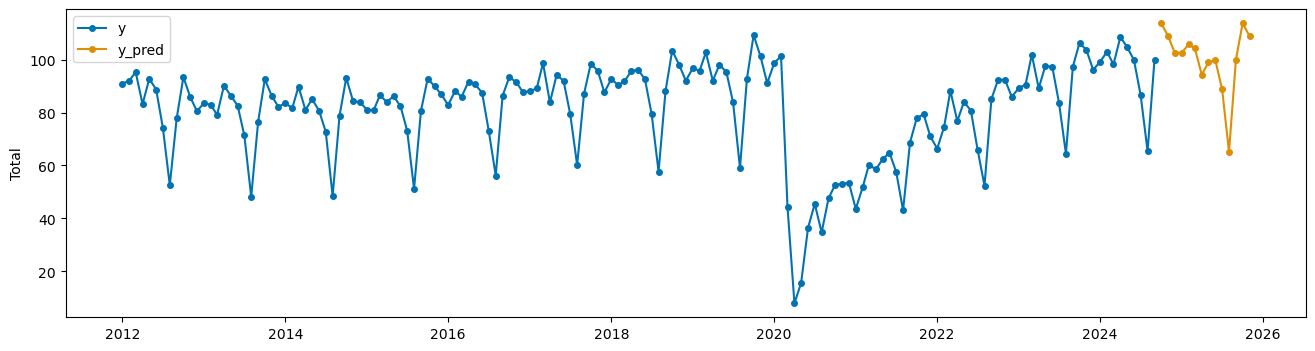

In [35]:
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])

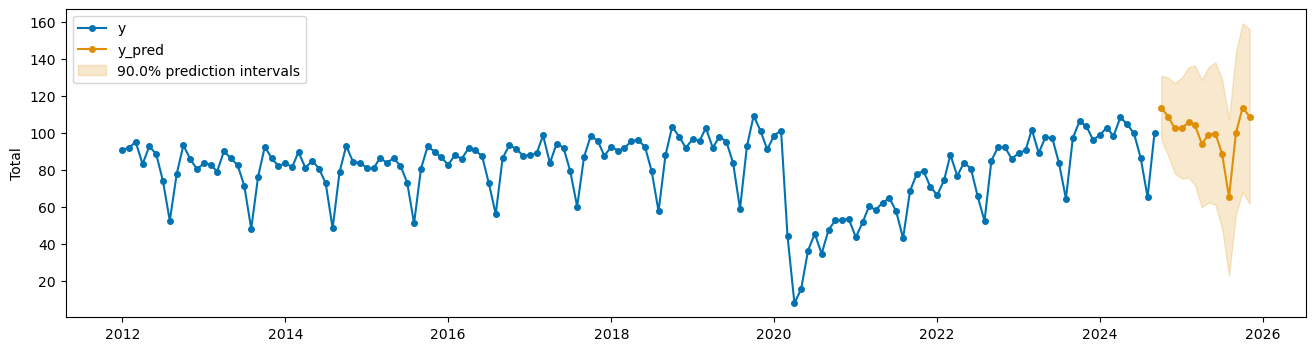

In [37]:

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints['Total', 0.9, 'lower'],
    y_pred_ints['Total', 0.9, 'upper'],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage*100}% prediction intervals",
)
ax.legend();

# De los datos, coge la linea perteneciente a las predicciones, y hazle un área a la linea pertenecientes a los 2 extremos del intervalo de 
# confianza, alpha = 0.2 le da transparencia

De los datos, coge la linea perteneciente a las predicciones, y hazle un área a la linea pertenecientes a los 2 extremos del intervalo de confianza.

Observamos como los intervalos de confianza al 90% de confianza son bastante grandes, esto significa que las predicciones no son muy buenas, ya que los valores pueden oscilar mucho dentro del intervalo. No nos interesa ya que la predicción generada puede ser en realidad un valor muy distinto.

Además, vemos que conforme avanza la predicción, el intervalo de confianza va aumentando. Tiene sentido ya que debido a la gran incertidumbre de nuestro sistema económico, se dificulta mucho la realización de buenas predicciones a largo plazo, pues no podemos predecir situaciones exógenas como crisis, guerras o pandemias que afectan a este tipo de servicios de transporte. Como podemos observar en marzo de 2020, causa del establecimiento del Estado de alarma fruto de la pandemia COVID-19.

## Predicción mediante Box-Cox


In [38]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

y = df_combined_month
transformer = BoxCoxTransformer()
y_hat = transformer.fit_transform(y)
y_hat.tail()

# cuando haces la transformación el IC pasa de ser simétrico a asimétrico. 
# al hacer la predicción tenemos que corregir el sesgo, deshacer el modelo transformado para predecir la serie original

,Total
2024-05,92661.533952
2024-06,81288.787726
2024-07,55570.880739
2024-08,26300.494995
2024-09,81685.239748


129 24


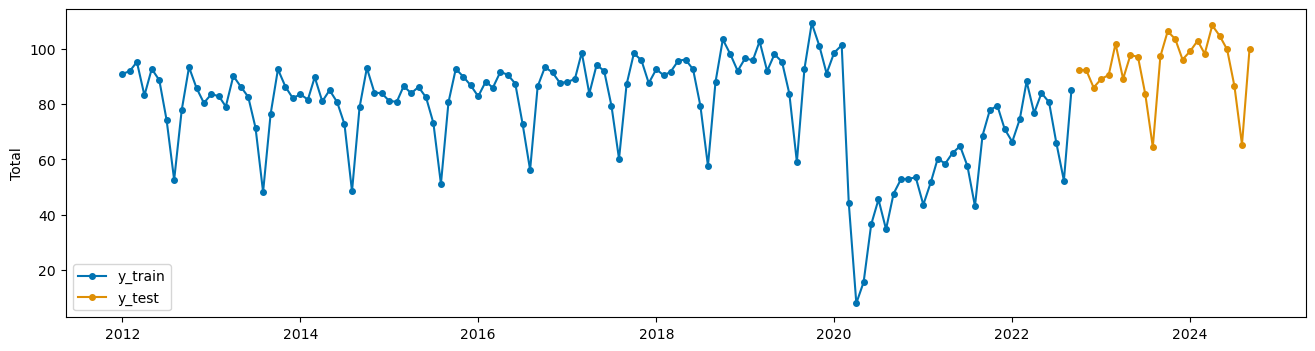

In [40]:
from sktime.forecasting.model_selection import temporal_train_test_split
y = df_combined_month
y_train, y_test = temporal_train_test_split(y, test_size=24)
# we will try to forecast y_test from y_train
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

Le pedimos que separe la serie en entrenamiento y test, y que el tamaño de test sea de 24 meses (2 años).

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total'>)

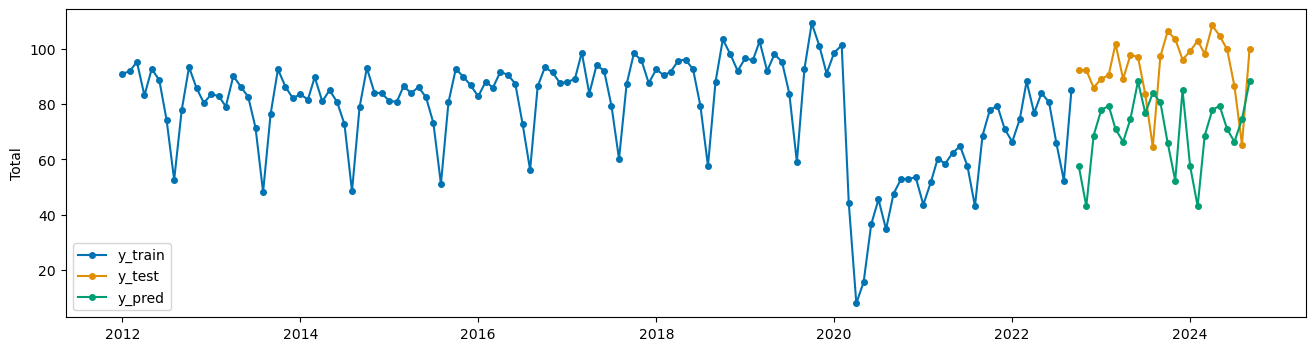

In [41]:
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=15)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)
# plotting for illustration
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

Vemos como a la predicción le falta la tendencia.

***

## Evaluación de la Precisión del Pronóstico

Para evaluar nuestras predicciones se usarán las siguientes métricas a lo largo de todo el proyecto:

**Mean Squared Error (MSE):**
El MSE mide el promedio de los cuadrados de los errores, donde el error es la diferencia entre los valores observados reales y las predicciones del modelo. Matemáticamente, se expresa como:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

Penaliza errores grandes de manera más severa debido al término cuadrático, por lo que es especialmente útil cuando se desea evitar grandes desviaciones en las predicciones.

**Root Mean Squared Error (RMSE):**
El RMSE es la raíz cuadrada del MSE y se calcula como:

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}$$

Esta métrica tiene la ventaja de estar en las mismas unidades que los datos originales, lo que facilita su interpretación. Es útil para evaluar la magnitud promedio de los errores en un contexto comprensible.

**Mean Absolute Percentage Error (MAPE):**
El MAPE mide el error promedio en términos relativos, expresado como un porcentaje. Se define como:

$$\text{MAPE} = \frac{1}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100$$

Es útil cuando se quiere entender la precisión de las predicciones en relación con los valores reales, ya que proporciona una medida escalable independientemente de las unidades de los datos. Sin embargo, es sensible a valores cercanos a cero en los datos reales.

Estas métricas, en conjunto, permiten evaluar tanto la magnitud de los errores (RMSE, MSE) como su impacto relativo (MAPE), brindando una visión más completa del rendimiento del modelo.

In [42]:
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

rmse = MeanSquaredError(square_root=True)
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError(symmetric=False)


print('Mean Squared Error (MSE):', mse(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse(y_test, y_pred))
print('Mean Absolute Percentage Error (MAPE):', mape(y_test, y_pred))

Mean Squared Error (MSE): 856.6242732500001
Root Mean Squared Error (RMSE): 29.268144342441666
Mean Absolute Percentage Error (MAPE): 0.26654456556708817


Los resultados de las métricas indican lo siguiente en el contexto de la predicción de pasajeros de metro y autobús en Madrid:

**Mean Squared Error (MSE): 856.624**

El MSE, al ser una medida basada en los cuadrados de los errores, refleja una penalización más alta para errores grandes. En este caso, un valor de 856.624 significa que, en promedio, los errores al cuadrado entre las predicciones y los valores reales son relativamente bajos, lo que sugiere que el modelo tiene un desempeño aceptable.

**Root Mean Squared Error (RMSE): 29.268**

El RMSE, que está en las mismas unidades que la serie original, indica que el error promedio por predicción es aproximadamente de 29 pasajeros. Esto proporciona una medida más tangible de los errores y sugiere que el modelo puede predecir con un margen de error moderado.

**Mean Absolute Percentage Error (MAPE): 0.267 (26.65%)**

El MAPE indica que, en promedio, las predicciones se desvían un 26.65% respecto a los valores reales. Aunque este valor podría ser considerado algo alto para ciertos contextos, depende de la variabilidad de la serie temporal. Como los datos muestran una gran estacionalidad, este nivel de error relativo es razonable, aunque no muy bueno.


El modelo tiene un desempeño aceptable, pero no perfecto, para predecir el número de pasajeros. El RMSE muestra que los errores en unidades absolutas son manejables, mientras que el MAPE sugiere que existe margen para mejorar la precisión relativa, tal vez ajustando el modelo para capturar mejor las tendencias o patrones específicos de la serie temporal, como la estacionalidad o los efectos de días específicos.

***

# Conclusión

Como he mencionado antes, estas predicciones que no son buenas a primera vista, me permiten poner en práctica conceptos necesarios para llevar a cabo las predicciones en modelos más robustos.

Después de haber introducido el esquema de predicción que vamos a llevar a cabo con nuestras series temporales, en los siguientes notebooks analizaremos las predicciones con modelos ARIMA, ETS, Theta, modelos de Machine learning, etc. Así como las métricas expuestas y comentadas anteriormente.